# Compute background of the BlockModel with `empymod`

In [1]:
import empymod
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook
plt.style.use('ggplot')

## Load model and survey

In [3]:
ds = xr.load_dataset('../block_model_and_survey.nc', engine='h5netcdf')

### Extract required info

In [4]:
# Model
res_h = ds.attrs['res1d']
aniso = ds.attrs['aniso']
depth = ds.attrs['depth']

# Survey
src = ds.attrs['src']
strength = ds.attrs['strength']
freq = ds.attrs['freq']
rec_x = ds.x.data[::2]
rec_y = ds.attrs['rec_y']
rec_z = ds.attrs['rec_z']

## Compute the responses

In [5]:
rec_X, rec_Y = np.meshgrid(rec_x, rec_y)

epm_1d = empymod.bipole(
    [*src], [rec_X.ravel(), rec_Y.ravel(), rec_z, 0, 0], depth,
    res_h, freq, aniso=aniso, srcpts=5, strength=strength,
    verb=3, htarg={'pts_per_dec': -1}
).reshape(rec_x.size, rec_y.size, order='F')


:: empymod START  ::

   depth       [m] :  -3150 -850 -600 0
   res     [Ohm.m] :  1000 2 1 0.3 1E+08
   aniso       [-] :  1 1.41421 1 1 1
   epermH      [-] :  1 1 1 1 1
   epermV      [-] :  1 1 1 1 1
   mpermH      [-] :  1 1 1 1 1
   mpermV      [-] :  1 1 1 1 1
   direct field    :  Calc. in wavenumber domain
   frequency  [Hz] :  1
   Hankel          :  DLF (Fast Hankel Transform)
     > Filter      :  Key 201 (2009)
     > DLF type    :  Lagged Convolution
   Kernel Opt.     :  None
   Loop over       :  Frequencies
   Source(s)       :  1 bipole(s)
     > intpts      :  5
     > length  [m] :  200
     > strength[A] :  800
     > x_c     [m] :  0
     > y_c     [m] :  0
     > z_c     [m] :  -550
     > azimuth [°] :  0
     > dip     [°] :  0
   Receiver(s)     :  303 dipole(s)
     > x       [m] :  -10000 - 10000 : 303  [min-max; #]
     > y       [m] :  -3000 - 3000 : 303  [min-max; #]
     > z       [m] :  -600
     > azimuth [°] :  0
     > dip     [°] :  0
   Required 

## Plot result

<IPython.core.display.Javascript object>


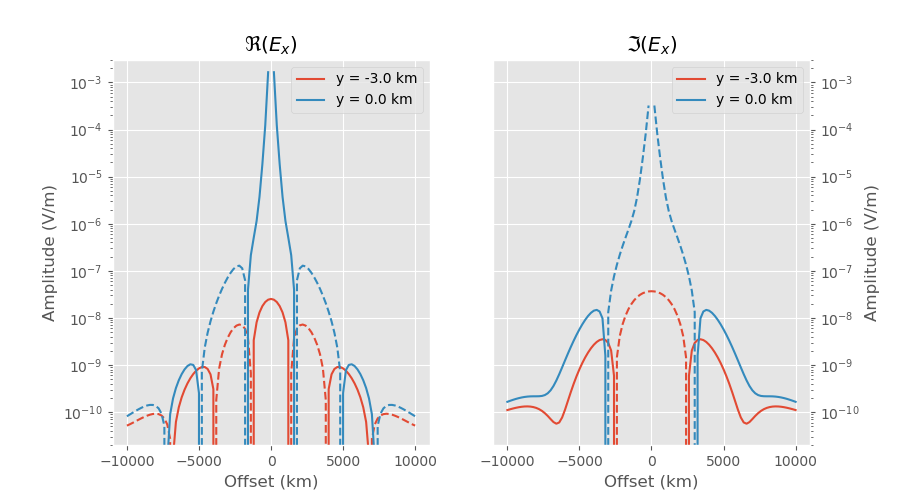

In [6]:
plt.figure(figsize=(9, 5))

# Real
ax1 = plt.subplot(121)
plt.title(r'$\Re(E_x)$')
for i, y in enumerate(rec_y[:2]):
    plt.plot(rec_x, epm_1d[:, i].real, f'C{i}-', label=f'y = {y/1e3} km')
    plt.plot(rec_x, -epm_1d[:, i].real, f'C{i}--')
    
plt.yscale('log')
plt.legend()
plt.xlabel('Offset (km)')
plt.ylabel('Amplitude (V/m)')

# Imaginary
ax2 = plt.subplot(122, sharey=ax1)
plt.title(r'$\Im(E_x)$')
for i, y in enumerate(rec_y[:2]):
    plt.plot(rec_x, epm_1d[:, i].imag, f'C{i}-', label=f'y = {y/1e3} km')
    plt.plot(rec_x, -epm_1d[:, i].imag, f'C{i}--')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.xlabel('Offset (km)')
plt.ylabel('Amplitude (V/m)')

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')

plt.show()

## Save `empymod`-data

In [7]:
ds.line_1.data = np.vstack([epm_1d[:, 0].real, epm_1d[:, 0].imag]).ravel('F')
ds.line_2.data = np.vstack([epm_1d[:, 1].real, epm_1d[:, 1].imag]).ravel('F')
ds.line_3.data = np.vstack([epm_1d[:, 2].real, epm_1d[:, 2].imag]).ravel('F')

# Add meta data
ds.attrs['runtime'] = '<1 s'
ds.attrs['n_procs'] = '1'
ds.attrs['max_ram'] = '0 MiB'
ds.attrs['n_cells'] = 'N/A'
ds.attrs['n_nodes'] = 'N/A'
ds.attrs['n_dof'] = 'N/A'
ds.attrs['extent'] = 'N/A'
ds.attrs['min_vol'] = 'N/A'
ds.attrs['max_vol'] = 'N/A'
ds.attrs['machine'] = "Laptop; i7-6600U CPU@2.6 GHz x4; 16 GB of memory, Ubuntu 18.04"
ds.attrs['version'] = f"empymod v{empymod.__version__}"
ds.attrs['date'] = datetime.today().isoformat()

# Save it under <{model}_{code}.nc>
ds.to_netcdf(f'../results/layered_empymod.nc', engine='h5netcdf')

In [8]:
empymod.Report(xr)

--------------------------------------------------------------------------------
  Date: Wed Apr 01 14:26:25 2020 CEST

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.7.6 (default, Jan  8 2020, 19:59:22)  [GCC 7.3.0]

            xarray : 0.15.0
             numpy : 1.15.4
             scipy : 1.4.1
           empymod : 1.10.6
           IPython : 7.13.0
        matplotlib : 3.1.3
--------------------------------------------------------------------------------